# Introduction to Data Analytics Coursework -- Text Analytics Data Loader

For this coursework, we recommend that you use your virtual environment that you created for the labs. Alternatively, create a fresh environment following the instructions in the [README.md in the intro-labs-public Github repository](https://github.com/uob-TextAnalytics/intro-labs-public). 

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

import numpy as np
import seaborn as sns
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
from bs4 import BeautifulSoup
import unicodedata
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Financial Question Answering Task 1 -- Sentiment Analysis (FiQA SA)

The FiQA SA dataset contains two sets of different instances: news headlines and social media posts. The data is available from the website of the FiQA competition: https://sites.google.com/view/fiqa/home . 

Each instance has a continuous sentiment score. Our task is to classify the posts into positive (2), negative (0) or neutral (1). First, load both the headlines and posts, along with their sentiment scores, then bin the scores into positive, negative and neutral:

In [2]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding="utf-8") as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [4]:
df = pd.DataFrame({'tweet':all_text, 'label':all_labels})
df.head()

,tweet,label
0,Royal Mail chairman Donald Brydon set to step ...,0
1,Stakes High for AstraZeneca Heart Drug Facing ...,0
2,UPDATE 1-Dairy Crest loses a third of Morrison...,1
3,Insight hires Aviva's David Hillier for multi-...,1
4,Primark racks up a happy Christmas after stron...,2


### WordCloud

In [5]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

negative_sent = df['tweet'][df['label'] == 0]
neutral_sent = df['tweet'][df['label'] == 1]
positive_sent = df['tweet'][df['label'] == 2]

def list_tokenizer(label):
    labels = " ".join(label)
    labels = word_tokenize(labels)
    return str(labels)

def word_cloud(label, number):
    wc = WordCloud(background_color='black', max_font_size=48, max_words=100)
    wc.generate(label)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for label: {number}')
    plt.axis('off')


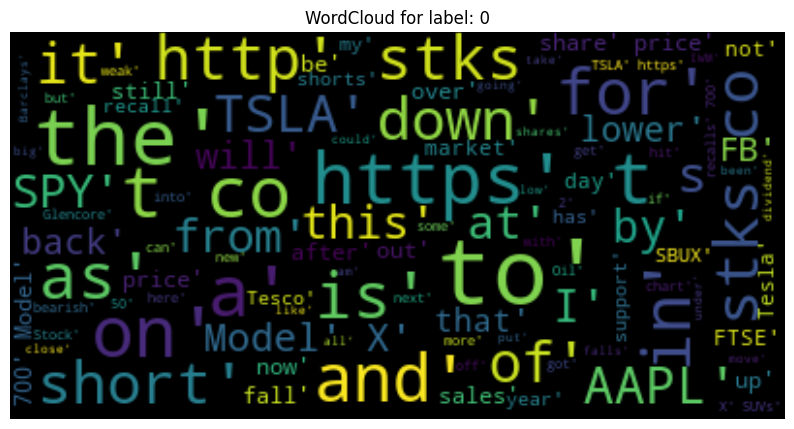

In [6]:
word_cloud(list_tokenizer(negative_sent), 0)

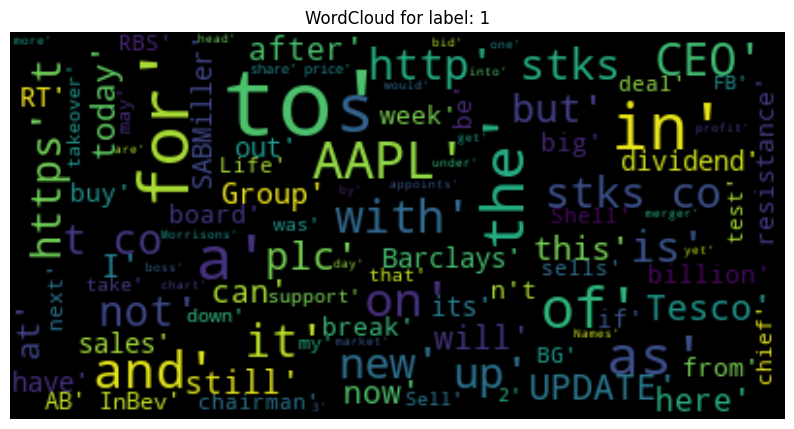

In [7]:
word_cloud(list_tokenizer(neutral_sent), 1)

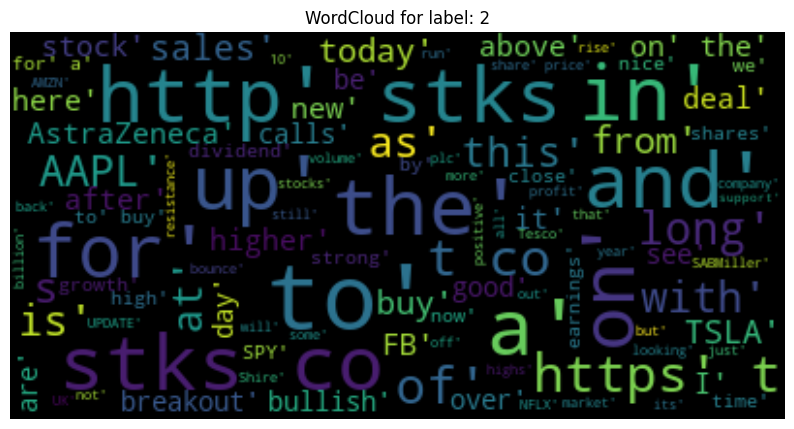

In [8]:
word_cloud(list_tokenizer(positive_sent), 2)

### Model without pre-processing the data

Let's create a test split, which we can hold out until we have tuned our method(s).

We may also need a _validation_ set (also called 'development' set or 'devset'), which can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation set does not use a single fixed validation set, but instead uses [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [9]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [10]:
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

WPP wins race for 'programmatic buying' agency Essence Digital
...and here is its corresponding label 

2


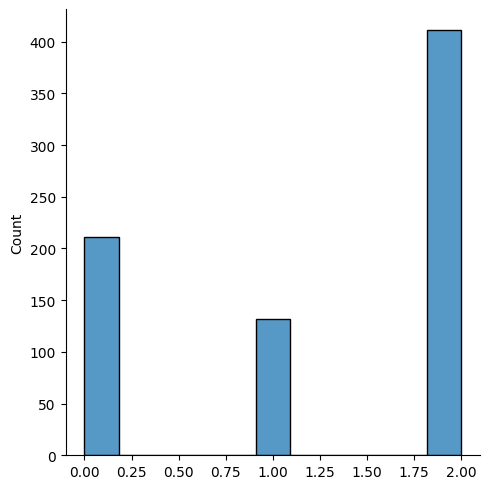

In [11]:
sns.displot(train_labels)

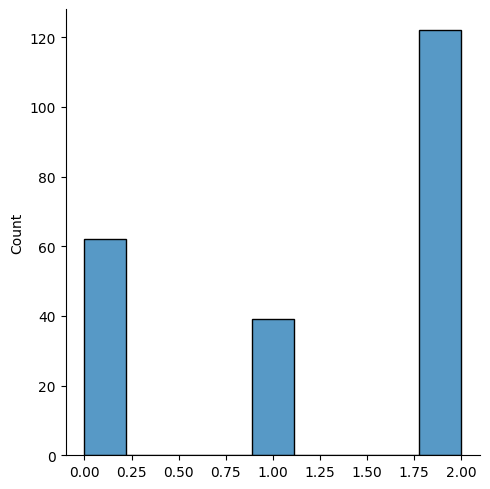

In [12]:
sns.displot(test_labels)

In [13]:
df_train = pd.DataFrame({'tweet':train_documents, 'label':train_labels})
df_train.head()

,tweet,label
0,$ROST Nov 90 calls 2.08 .. Go Long until exp i...,2
1,Entering long Lockheed Martin $LMT at Thursday...,2
2,@chessNwine: $IWM 30-Minute Chart. Small caps ...,0
3,UPDATE 5-Barclays Chairman McFarlane axes CEO ...,0
4,$CDTI bounce here on support or H&S setup this...,2


In [14]:
vectorizer = CountVectorizer()
Xtrain_bow = vectorizer.fit_transform(train_documents).toarray()
Xval_bow = vectorizer.transform(val_documents).toarray()
Xtest_bow = vectorizer.transform(test_documents).toarray()

##### 1. MultinomialNB

In [15]:
clf_bow = MultinomialNB().fit(Xtrain_bow, train_labels)
pred_bow = clf_bow.predict(Xval_bow)

In [16]:
print(f"Confusion Matrix:\n {confusion_matrix(pred_bow, val_labels)}")
print(f"Accuracy:\n {accuracy_score(pred_bow, val_labels)}")
print(f"Classification Report:\n {classification_report(pred_bow, val_labels)}")

Confusion Matrix:
 [[21  3  5]
 [ 0  5  1]
 [16 16 67]]
Accuracy:
 0.6940298507462687
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.72      0.64        29
           1       0.21      0.83      0.33         6
           2       0.92      0.68      0.78        99

    accuracy                           0.69       134
   macro avg       0.56      0.74      0.58       134
weighted avg       0.81      0.69      0.73       134



In [17]:
test_bow = clf_bow.predict(Xtest_bow)
print(f"Accuracy:\n {accuracy_score(test_bow, test_labels)}")

Accuracy:
 0.6188340807174888


##### 2. Logistic Regression

In [18]:
unprecessed_lr = LogisticRegression().fit(Xtrain_bow, train_labels)
unprecessed_lr_pred_bow = unprecessed_lr.predict(Xval_bow)

In [19]:
print(f"Confusion Matrix:\n {confusion_matrix(unprecessed_lr_pred_bow, val_labels)}")
print(f"Accuracy:\n {accuracy_score(unprecessed_lr_pred_bow, val_labels)}")
print(f"Classification Report:\n {classification_report(unprecessed_lr_pred_bow, val_labels)}")

Confusion Matrix:
 [[20  7  5]
 [ 1  4  3]
 [16 13 65]]
Accuracy:
 0.664179104477612
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58        32
           1       0.17      0.50      0.25         8
           2       0.89      0.69      0.78        94

    accuracy                           0.66       134
   macro avg       0.53      0.61      0.54       134
weighted avg       0.76      0.66      0.70       134



##### 3. Naive Bayes

In [20]:
unprecessed_nb = GaussianNB().fit(Xtrain_bow, train_labels)
unprecessed_nb_pred_bow = unprecessed_nb.predict(Xval_bow)

In [21]:
print(f"Confusion Matrix:\n {confusion_matrix(unprecessed_nb_pred_bow, val_labels)}")
print(f"Accuracy:\n {accuracy_score(unprecessed_nb_pred_bow, val_labels)}")
print(f"Classification Report:\n {classification_report(unprecessed_nb_pred_bow, val_labels)}")

Confusion Matrix:
 [[17  6 11]
 [ 8  9 12]
 [12  9 50]]
Accuracy:
 0.5671641791044776
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48        34
           1       0.38      0.31      0.34        29
           2       0.68      0.70      0.69        71

    accuracy                           0.57       134
   macro avg       0.51      0.50      0.50       134
weighted avg       0.56      0.57      0.56       134



### Pre-porcessing

In [22]:
# Lowercase everything
all_text_processed = np.char.lower(all_text)
all_text_processed[:5]

array(['royal mail chairman donald brydon set to step down',
       'stakes high for astrazeneca heart drug facing tough competition',
       'update 1-dairy crest loses a third of morrisons milk contract',
       "insight hires aviva's david hillier for multi-asset team",
       'primark racks up a happy christmas after strong sales'],
      dtype='<U142')

In [23]:
# Regex to remove emails from tweets
email_pattern = r'/\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
all_text_processed = np.vectorize(lambda x: re.sub(email_pattern, '', x))(all_text_processed)

In [24]:
# Getting rid of URLs from the tweets
url_pattern = r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?'
all_text_processed = np.vectorize(lambda x: re.sub(url_pattern, '', x))(all_text_processed)

In [25]:
# Get rid of re-tweets
all_text_processed = np.vectorize(lambda x: re.sub('RT', '', x))(all_text_processed)

In [26]:
# Getting rid of punctuations
all_text_processed = np.vectorize(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))(all_text_processed)

In [27]:
# Removing multiple whitespaces if exist
all_text_processed = np.vectorize(lambda x: " ".join(x.split()))(all_text_processed)

In [28]:
# Removing HTML tags
all_text_processed = np.vectorize(lambda x: BeautifulSoup(x, 'lxml').get_text())(all_text_processed)

In [29]:
# Normalize accented chars (Déjà vu -> Deja vu)
def norm_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

all_text_processed = np.vectorize(norm_accented_chars)(all_text_processed)

In [30]:
all_text_processed = [WordNetLemmatizer().lemmatize(word) for word in all_text_processed]

In [31]:
all_text_processed

['royal mail chairman donald brydon set to step down',
 'stakes high for astrazeneca heart drug facing tough competition',
 'update 1-dairy crest loses a third of morrisons milk contract',
 'insight hires avivas david hillier for multi-asset team',
 'primark racks up a happy christmas after strong sales',
 'update 1-pearson expects to grow this year after solid end to 2014',
 'tesco sells blinkbox and broadband service to talktalk',
 'unilever profit rises despite sales slump in china',
 'tesco leads leap in ftse 100 marks spencer drops',
 'royal dutch shell profit rises dividend up 4',
 'morning agenda shires deal for nps',
 'carnival corporation and china merchants group sign memo of understanding',
 'teva fda approves generic version of astrazeneca heartburn drug',
 'passengers rise at easyjet and aer lingus',
 'tesco abandons video-streaming ambitions in blinkbox sale',
 'fda approves nps drug in move validating shire takeover deal',
 'ocwen reaches settlement with california regul

### Model Building
#### Splitting the data into train, test and validation sets

In [32]:
# Split test data from training data
p_train_documents, p_test_documents, p_train_labels, p_test_labels = train_test_split(
    all_text_processed, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
p_train_documents, p_val_documents, p_train_labels, p_val_labels = train_test_split(
    p_train_documents, 
    p_train_labels, 
    test_size=0.15, 
    stratify=p_train_labels,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

In [33]:
p_vectorizer = CountVectorizer()
p_Xtrain_bow = p_vectorizer.fit_transform(p_train_documents).toarray()
p_Xval_bow = p_vectorizer.transform(p_val_documents).toarray()
p_Xtest_bow = p_vectorizer.transform(p_test_documents).toarray()

#### Building models

##### 1. Multinomial Naive Bayes Model

In [34]:
p_clf_bow = MultinomialNB().fit(p_Xtrain_bow, p_train_labels)
p_pred_bow = p_clf_bow.predict(p_Xval_bow)

In [35]:
print(f"Confusion Matrix:\n {confusion_matrix(p_pred_bow, p_val_labels)}")
print(f"Accuracy:\n {accuracy_score(p_pred_bow, p_val_labels)}")
print(f"Classification Report:\n {classification_report(p_pred_bow, p_val_labels)}")

Confusion Matrix:
 [[23  3  4]
 [ 0  5  1]
 [14 16 68]]
Accuracy:
 0.7164179104477612
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.77      0.69        30
           1       0.21      0.83      0.33         6
           2       0.93      0.69      0.80        98

    accuracy                           0.72       134
   macro avg       0.59      0.76      0.61       134
weighted avg       0.83      0.72      0.75       134



##### Testing

In [36]:
p_test_bow = p_clf_bow.predict(p_Xtest_bow)

In [37]:
print(f"Confusion Matrix:\n {confusion_matrix(p_test_bow, p_test_labels)}")
print(f"Accuracy:\n {accuracy_score(p_test_bow, p_test_labels)}")
print(f"Classification Report:\n {classification_report(p_test_bow, p_test_labels)}")

Confusion Matrix:
 [[ 21   3  12]
 [  5   7   5]
 [ 36  29 105]]
Accuracy:
 0.5964125560538116
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.58      0.43        36
           1       0.18      0.41      0.25        17
           2       0.86      0.62      0.72       170

    accuracy                           0.60       223
   macro avg       0.46      0.54      0.47       223
weighted avg       0.72      0.60      0.64       223



##### 2. Naive Bayes (Using BOW)

In [38]:
gaussian_clf = GaussianNB()
gaussian_clf.fit(p_Xtrain_bow, p_train_labels)
gaussian_clf_pred = gaussian_clf.predict(p_Xval_bow)

In [39]:
print(f"Confusion Matrix:\n {confusion_matrix(gaussian_clf_pred, p_val_labels)}")
print(f"Accuracy:\n {accuracy_score(gaussian_clf_pred, p_val_labels)}")
print(f"Classification Report:\n {classification_report(gaussian_clf_pred, p_val_labels)}")

Confusion Matrix:
 [[18  7 12]
 [ 7  9 13]
 [12  8 48]]
Accuracy:
 0.5597014925373134
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.49      0.49        37
           1       0.38      0.31      0.34        29
           2       0.66      0.71      0.68        68

    accuracy                           0.56       134
   macro avg       0.51      0.50      0.50       134
weighted avg       0.55      0.56      0.55       134



##### TF-IDF

In [40]:
#corpus = all_text_processed.tolist()
tfidf_clf = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3))
X = tfidf_clf.fit_transform(all_text_processed).toarray()
y = all_labels

In [41]:
## Splitting the data in train, test and val sets

# Split test data from training data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=all_labels,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.15, 
    stratify=y_train,
    random_state=1729  # make sure the same proportion of labels is in the test set and training set
)

In [42]:
count_df = pd.DataFrame(X_train, columns = tfidf_clf.get_feature_names_out())

In [43]:
count_df.head()

,037,047,10,10 percent,10 powered,10 powered by,100,100 and,100 billion,100 movers,...,yhoo,yndx,you,you buy,your,znga,zone,zs,zs pharma,zs pharma for
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 3. Naive Bayes (TF-IDF)

In [44]:
gaussian_clf.fit(X_train, y_train)
gaussian_clf_pred = gaussian_clf.predict(X_val)

In [45]:
print(f"Confusion Matrix:\n {confusion_matrix(gaussian_clf_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(gaussian_clf_pred, y_val)}")
print(f"Classification Report:\n {classification_report(gaussian_clf_pred, y_val)}")

Confusion Matrix:
 [[20  7  7]
 [ 2  7  7]
 [15 10 59]]
Accuracy:
 0.6417910447761194
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.59      0.56        34
           1       0.29      0.44      0.35        16
           2       0.81      0.70      0.75        84

    accuracy                           0.64       134
   macro avg       0.55      0.58      0.55       134
weighted avg       0.68      0.64      0.66       134



##### 4. MultinomialNB (TF-IDF)

In [46]:
mNB = MultinomialNB()
mNB.fit(X_train, y_train)
mNB_pred = mNB.predict(X_val)

In [47]:
print(f"Confusion Matrix:\n {confusion_matrix(mNB_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(mNB_pred, y_val)}")
print(f"Classification Report:\n {classification_report(mNB_pred, y_val)}")

Confusion Matrix:
 [[ 5  1  0]
 [ 0  1  0]
 [32 22 73]]
Accuracy:
 0.5895522388059702
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.83      0.23         6
           1       0.04      1.00      0.08         1
           2       1.00      0.57      0.73       127

    accuracy                           0.59       134
   macro avg       0.39      0.80      0.35       134
weighted avg       0.95      0.59      0.70       134



##### 5. XGBoost

In [48]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_val)

In [49]:
print(f"Confusion Matrix:\n {confusion_matrix(xgb_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(xgb_pred, y_val)}")
print(f"Classification Report:\n {classification_report(xgb_pred, y_val)}")

Confusion Matrix:
 [[18  5  9]
 [ 3  6  4]
 [16 13 60]]
Accuracy:
 0.6268656716417911
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.56      0.52        32
           1       0.25      0.46      0.32        13
           2       0.82      0.67      0.74        89

    accuracy                           0.63       134
   macro avg       0.52      0.57      0.53       134
weighted avg       0.69      0.63      0.65       134



In [50]:
xgb_test = xgb_classifier.predict(X_test)

In [51]:
print(f"Confusion Matrix:\n {confusion_matrix(xgb_test, y_test)}")
print(f"Accuracy:\n {accuracy_score(xgb_test, y_test)}")
print(f"Classification Report:\n {classification_report(xgb_test, y_test)}")

Confusion Matrix:
 [[ 26   6  12]
 [  2   4   7]
 [ 34  29 103]]
Accuracy:
 0.5964125560538116
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.59      0.49        44
           1       0.10      0.31      0.15        13
           2       0.84      0.62      0.72       166

    accuracy                           0.60       223
   macro avg       0.46      0.51      0.45       223
weighted avg       0.72      0.60      0.64       223



##### 6. Logistic Regression

In [52]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

In [53]:
print(f"Confusion Matrix:\n {confusion_matrix(lr_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(lr_pred, y_val)}")
print(f"Classification Report:\n {classification_report(lr_pred, y_val)}")

Confusion Matrix:
 [[12  3  0]
 [ 0  1  0]
 [25 20 73]]
Accuracy:
 0.6417910447761194
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.80      0.46        15
           1       0.04      1.00      0.08         1
           2       1.00      0.62      0.76       118

    accuracy                           0.64       134
   macro avg       0.46      0.81      0.44       134
weighted avg       0.92      0.64      0.73       134



##### 7. SVM (TF-IDF)

In [54]:
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
linear_svm_pred = linear_svm.predict(X_val)

In [55]:
print(f"Confusion Matrix:\n {confusion_matrix(linear_svm_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(linear_svm_pred, y_val)}")
print(f"Classification Report:\n {classification_report(linear_svm_pred, y_val)}")

Confusion Matrix:
 [[18  3  2]
 [ 0  2  0]
 [19 19 71]]
Accuracy:
 0.6791044776119403
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.78      0.60        23
           1       0.08      1.00      0.15         2
           2       0.97      0.65      0.78       109

    accuracy                           0.68       134
   macro avg       0.51      0.81      0.51       134
weighted avg       0.88      0.68      0.74       134



In [56]:
parameters = {
    'C': [0.1, 1.0, 10, 100, 1000],
     'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto', 'scale'],
     'kernel': ['linear', 'sigmoid']
}

model = GridSearchCV(SVC(), parameters, refit=True).fit(X_train, y_train)
y_pred = model.predict(X_val)

In [57]:
print(f"Confusion Matrix:\n {confusion_matrix(y_pred, y_val)}")
print(f"Accuracy:\n {accuracy_score(y_pred, y_val)}")
print(f"Classification Report:\n {classification_report(y_pred, y_val)}")

Confusion Matrix:
 [[18  3  1]
 [ 0  2  0]
 [19 19 72]]
Accuracy:
 0.6865671641791045
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.82      0.61        22
           1       0.08      1.00      0.15         2
           2       0.99      0.65      0.79       110

    accuracy                           0.69       134
   macro avg       0.52      0.82      0.52       134
weighted avg       0.89      0.69      0.75       134



In [58]:
model.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}

In [59]:
svc_test = model.predict(X_test)

In [60]:
print(f"Confusion Matrix:\n {confusion_matrix(svc_test, y_test)}")
print(f"Accuracy:\n {accuracy_score(svc_test, y_test)}")
print(f"Classification Report:\n {classification_report(svc_test, y_test)}")

Confusion Matrix:
 [[ 26   2   8]
 [  0   5   1]
 [ 36  32 113]]
Accuracy:
 0.6457399103139013
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.72      0.53        36
           1       0.13      0.83      0.22         6
           2       0.93      0.62      0.75       181

    accuracy                           0.65       223
   macro avg       0.49      0.73      0.50       223
weighted avg       0.82      0.65      0.70       223



##### 8. SVM (BOW)

In [61]:
linear_svm_bow = SVC(kernel='linear')
linear_svm_bow.fit(p_Xtrain_bow, p_train_labels)
linear_svm_bow_pred = linear_svm_bow.predict(p_Xval_bow)

In [62]:
print(f"Confusion Matrix:\n {confusion_matrix(linear_svm_bow_pred, p_val_labels)}")
print(f"Accuracy:\n {accuracy_score(linear_svm_bow_pred, p_val_labels)}")
print(f"Classification Report:\n {classification_report(linear_svm_bow_pred, p_val_labels)}")

Confusion Matrix:
 [[21  9  6]
 [ 1  7  5]
 [15  8 62]]
Accuracy:
 0.6716417910447762
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.58      0.58        36
           1       0.29      0.54      0.38        13
           2       0.85      0.73      0.78        85

    accuracy                           0.67       134
   macro avg       0.57      0.62      0.58       134
weighted avg       0.72      0.67      0.69       134



<span style="color:green">SVM produces same output with TF-IDF and Bag of Words.</span>

## New Dataset ([financial_phrasebank](!https://huggingface.co/datasets/financial_phrasebank))

In [93]:
filenames = [#r'data_cache/Sentences_50Agree.txt', \
             #r'data_cache/Sentences_66Agree.txt', \
             #r'data_cache/Sentences_75Agree.txt', \
             r'data_cache/Sentences_AllAgree.txt']

sentences = {'tweet': [], 'label': []}

for i in filenames:
    with open(i, 'r', encoding='Latin-1') as file:
        data = file.readlines()

    for line in data:
        try:
            sentence, label = line.split('.@')
            sentences['tweet'].append(sentence)
            sentences['label'].append(label.strip())
        except ValueError:
            #skip line if there's an error
            pass

new_df = pd.DataFrame.from_dict(sentences)
new_df['label'].replace({'negative':0, 'neutral':1, 'positive':2}, inplace=True)
new_df

,tweet,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2203,Operating result for the 12-month period decre...,0
2204,HELSINKI Thomson Financial - Shares in Cargote...,0
2205,LONDON MarketWatch -- Share prices ended lower...,0
2206,Operating profit fell to EUR 35.4 mn from EUR ...,0


Pre-processing new data

In [82]:
# Lowercase everything
new_df['tweet'] = new_df['tweet'].apply(lambda x: x.lower())

# Regex to remove emails from text
new_df['tweet'] = new_df['tweet'].apply(lambda x: re.sub(email_pattern, '', x))

# Getting rid of URLs from the text
new_df['tweet'] = new_df['tweet'].apply(lambda x: re.sub(url_pattern, '', x))

# Get rid of re-tweets
new_df['tweet'] = new_df['tweet'].apply(lambda x: re.sub('RT', '', x))

# Getting rid of punctuations
new_df['tweet'] = new_df['tweet'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))

# Removing multiple whitespaces if exist
new_df['tweet'] = new_df['tweet'].apply(lambda x: " ".join(x.split()))

# Removing HTML tags
new_df['tweet'] = new_df['tweet'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

# Normalize accented chars (Déjà vu -> Deja vu)
def norm_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

# Normalize accented chars
new_df['tweet'] = new_df['tweet'].apply(lambda x: norm_accented_chars(x))

In [84]:
old_df = pd.DataFrame({'tweet':p_train_documents, 'label':p_train_labels})

In [85]:
result_df = pd.concat([old_df, new_df], axis=0).reset_index(drop=True)

In [86]:
result_df

,tweet,label
0,rost nov 90 calls 208 go long until exp imo un...,2
1,entering long lockheed martin lmt at thursdays...,2
2,chessnwine iwm 30-minute chart small caps thre...,0
3,update 5-barclays chairman mcfarlane axes ceo ...,0
4,cdti bounce here on support or hs setup this a...,2
...,...,...
15170,operating result for the 12-month period decre...,0
15171,helsinki thomson financial - shares in cargote...,0
15172,london marketwatch -- share prices ended lower...,0
15173,operating profit fell to eur 354 mn from eur 6...,0


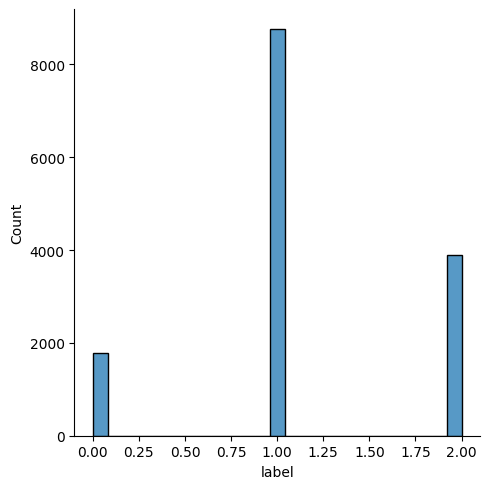

In [87]:
sns.displot(new_df['label'])

In [88]:
new_vectorizer = CountVectorizer()
new_Xtrain_bow = new_vectorizer.fit_transform(result_df['tweet']).toarray()
new_Xval_bow = new_vectorizer.transform(p_val_documents).toarray()
new_Xtest_bow = new_vectorizer.transform(p_test_documents).toarray()

In [89]:
new_linear_svm_bow = SVC(kernel='linear')
new_linear_svm_bow.fit(new_Xtrain_bow, result_df['label'])
new_linear_svm_bow_pred = new_linear_svm_bow.predict(new_Xval_bow)

In [90]:
print(f"Confusion Matrix:\n {confusion_matrix(new_linear_svm_bow_pred, p_val_labels)}")
print(f"Accuracy:\n {accuracy_score(new_linear_svm_bow_pred, p_val_labels)}")
print(f"Classification Report:\n {classification_report(new_linear_svm_bow_pred, p_val_labels)}")

Confusion Matrix:
 [[22  8 12]
 [ 7 12 11]
 [ 8  4 50]]
Accuracy:
 0.6268656716417911
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.52      0.56        42
           1       0.50      0.40      0.44        30
           2       0.68      0.81      0.74        62

    accuracy                           0.63       134
   macro avg       0.59      0.58      0.58       134
weighted avg       0.62      0.63      0.62       134



In [91]:
new_linear_svm_bow_test = new_linear_svm_bow.predict(new_Xtest_bow)

In [92]:
print(f"Confusion Matrix:\n {confusion_matrix(new_linear_svm_bow_test, p_test_labels)}")
print(f"Accuracy:\n {accuracy_score(new_linear_svm_bow_test, p_test_labels)}")
print(f"Classification Report:\n {classification_report(new_linear_svm_bow_test, p_test_labels)}")

Confusion Matrix:
 [[33 10 13]
 [12 14 40]
 [17 15 69]]
Accuracy:
 0.5201793721973094
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56        56
           1       0.36      0.21      0.27        66
           2       0.57      0.68      0.62       101

    accuracy                           0.52       223
   macro avg       0.49      0.49      0.48       223
weighted avg       0.50      0.52      0.50       223



## <span style="color:yellow">All tweets and newest data together

In [75]:
old_df_full = pd.DataFrame({'tweet':all_text, 'label':all_labels})

In [76]:
result_df2 = pd.concat([old_df_full, new_df], axis=0).reset_index(drop=True)

# BIONLP 2004

This dataset contains abstracts from MEDLINE, a database containing journal articles from fields including medicine and pharmacy. 
The data was collected by searching for the terms ‘human’, ‘blood cells’ and ‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line, RNA. 

More information in the paper: https://aclanthology.org/W04-1213.pdf

The data can be downloaded from HuggingFace: https://huggingface.co/datasets/tner/bionlp2004

In [ ]:
dataset = load_dataset(
    "tner/bionlp2004", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Found cached dataset bionlp2004 (/mnt/d/Data Science MSc/Intro to DA/Coursework/data_cache/tner___bionlp2004/bionlp2004/1.0.0/9f41d3f0270b773c2762dee333ae36c29331e2216114a57081f77639fdb5e904)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 16619
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1927
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 3856
    })
})


The dataset is already split into train, validation and test. It may be useful to reformat the DatasetDict object into lists of sentences and tags:

In [ ]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [ ]:
print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')
print(f'Number of test sentences = {len(test_sentences_ner)}')

Number of training sentences = 16619
Number of validation sentences = 1927
Number of test sentences = 3856


In [ ]:
print(f'What does one instance look like from the training set? \n\n{train_sentences_ner[234]}')
print(f'...and here is its corresponding label \n\n{train_labels_ner[234]}')

What does one instance look like from the training set? 

['Hence', ',', 'PPAR', 'can', 'positively', 'or', 'negatively', 'influence', 'TH', 'action', 'depending', 'on', 'TRE', 'structure', 'and', 'THR', 'isotype', '.']
...and here is its corresponding label 

['0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '3', '4', '0']


In [ ]:
print(f'Number of unique labels: {np.unique(np.concatenate(train_labels_ner))}')

Number of unique labels: ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


These are the tags used to annotate the entities:

In [ ]:
# mapping from labels to the tags

id2label = {
    "O": 0,
    "B-DNA": 1,
    "I-DNA": 2,
    "B-protein": 3,
    "I-protein": 4,
    "B-cell_type": 5,
    "I-cell_type": 6,
    "B-cell_line": 7,
    "I-cell_line": 8,
    "B-RNA": 9,
    "I-RNA": 10
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-DNA', 2: 'I-DNA', 3: 'B-protein', 4: 'I-protein', 5: 'B-cell_type', 6: 'I-cell_type', 7: 'B-cell_line', 8: 'I-cell_line', 9: 'B-RNA', 10: 'I-RNA'}
